In [1]:
from data_loader import *
dataset = FNNDataset(root='data', feature='profile', empty=False, name='politifact', transform=ToUndirected())

In [2]:
dataset

politifact(314)

In [3]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: politifact(314):
Number of graphs: 314
Number of features: 10
Number of classes: 2

Data(edge_index=[2, 1489], x=[497, 10], y=[1])
Number of nodes: 497
Number of edges: 1489
Average node degree: 3.00
Has isolated nodes: False
Has self-loops: True
Is undirected: True


In [4]:
torch.manual_seed(5008)
dataset = dataset.shuffle()

train_dataset = dataset[:250]
test_dataset = dataset[250:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 250
Number of test graphs: 64


In [5]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 25987], x=[8705, 10], y=[64], batch=[8705], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 26722], x=[8950, 10], y=[64], batch=[8950], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
Batch(edge_index=[2, 25468], x=[8532, 10], y=[64], batch=[8532], ptr=[65])

Step 4:
Number of graphs in the current batch: 58
Batch(edge_index=[2, 21913], x=[7343, 10], y=[58], batch=[7343], ptr=[59])



In [6]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(5008)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        emb = x 
        return emb,x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [7]:
##from IPython.display import Javascript
##display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         emb, out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         emb , out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 61):
    train()
    train_acc = test(train_loader)
    #test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')##', Test Acc: {test_acc:.4f}')
test_acc = test(test_loader)

Epoch: 001, Train Acc: 0.5960
Epoch: 002, Train Acc: 0.7080
Epoch: 003, Train Acc: 0.7840
Epoch: 004, Train Acc: 0.7960
Epoch: 005, Train Acc: 0.7920
Epoch: 006, Train Acc: 0.7880
Epoch: 007, Train Acc: 0.7760
Epoch: 008, Train Acc: 0.7960
Epoch: 009, Train Acc: 0.7840
Epoch: 010, Train Acc: 0.7920
Epoch: 011, Train Acc: 0.7920
Epoch: 012, Train Acc: 0.8080
Epoch: 013, Train Acc: 0.8080
Epoch: 014, Train Acc: 0.7960
Epoch: 015, Train Acc: 0.8080
Epoch: 016, Train Acc: 0.8120
Epoch: 017, Train Acc: 0.8040
Epoch: 018, Train Acc: 0.8000
Epoch: 019, Train Acc: 0.8000
Epoch: 020, Train Acc: 0.8000
Epoch: 021, Train Acc: 0.8000
Epoch: 022, Train Acc: 0.8000
Epoch: 023, Train Acc: 0.8080
Epoch: 024, Train Acc: 0.8000
Epoch: 025, Train Acc: 0.8280
Epoch: 026, Train Acc: 0.8120
Epoch: 027, Train Acc: 0.8120
Epoch: 028, Train Acc: 0.8160
Epoch: 029, Train Acc: 0.8120
Epoch: 030, Train Acc: 0.8200
Epoch: 031, Train Acc: 0.8160
Epoch: 032, Train Acc: 0.8240
Epoch: 033, Train Acc: 0.8240
Epoch: 034

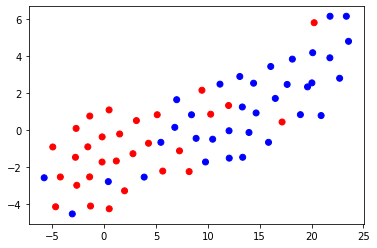

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
color_list = ["red",  "blue"]

#loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for data in test_loader:
    emb, pred = model(data.x, data.edge_index, data.batch)
    embs.append(emb)
    colors += [color_list[y-1] for y in data.y] # True label에 해당하는 color 선
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)

In [9]:
test_acc

0.796875

In [10]:
from torch_geometric.nn import GraphConv


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, 3)
        self.lin = Linear(3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        emb = x 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return emb, x

model = GNN(hidden_channels=64)
print(model)

GNN(
  (conv1): GraphConv(10, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 3)
  (lin): Linear(in_features=3, out_features=2, bias=True)
)


In [11]:
model = GNN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 61):
    train()
    train_acc = test(train_loader)
    ##test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')##, Test Acc: {test_acc:.4f}')

GNN(
  (conv1): GraphConv(10, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 3)
  (lin): Linear(in_features=3, out_features=2, bias=True)
)
Epoch: 001, Train Acc: 0.4600
Epoch: 002, Train Acc: 0.5120
Epoch: 003, Train Acc: 0.4320
Epoch: 004, Train Acc: 0.5560
Epoch: 005, Train Acc: 0.6080
Epoch: 006, Train Acc: 0.6320
Epoch: 007, Train Acc: 0.6600
Epoch: 008, Train Acc: 0.7480
Epoch: 009, Train Acc: 0.8120
Epoch: 010, Train Acc: 0.7840
Epoch: 011, Train Acc: 0.8200
Epoch: 012, Train Acc: 0.8240
Epoch: 013, Train Acc: 0.8240
Epoch: 014, Train Acc: 0.8360
Epoch: 015, Train Acc: 0.8160
Epoch: 016, Train Acc: 0.8160
Epoch: 017, Train Acc: 0.8200
Epoch: 018, Train Acc: 0.8200
Epoch: 019, Train Acc: 0.8320
Epoch: 020, Train Acc: 0.8240
Epoch: 021, Train Acc: 0.7880
Epoch: 022, Train Acc: 0.8160
Epoch: 023, Train Acc: 0.7840
Epoch: 024, Train Acc: 0.8160
Epoch: 025, Train Acc: 0.8200
Epoch: 026, Train Acc: 0.7840
Epoch: 027, Train Acc: 0.8240
Epoch: 028, Train Acc: 0.8400
Epoch: 02

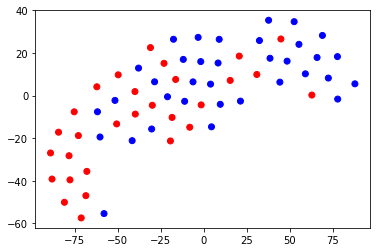

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
color_list = ["red",  "blue"]

#loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for data in test_loader:
    emb, pred = model(data.x, data.edge_index, data.batch)
    embs.append(emb)
    colors += [color_list[y-1] for y in data.y] # True label에 해당하는 color 선
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)

In [13]:
test_acc

0.796875